In [103]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool

FORECAST_STEPS = 23


## 1. Load and encode the data into numbers

In [104]:
# Load the dataset (replace 'your_dataset.csv' with your file path)
df = pd.read_csv('../data/intermig/train_data-medianimputed.csv')
df = df.drop('ind_launch_date', axis=1)


date_cols = ['launch_date', 'date']

# Process date columns
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df = df.drop(col, axis=1)

categoric_cols = ['brand', 'cluster_nl', 'corporation', 'country', 'drug_id', 'therapeutic_area']

# Process categorical columns
label_encoders = {}
for col in categoric_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    df = df.drop(col, axis=1)

# Handle indication column (contains lists)
mlb = MultiLabelBinarizer()
# Convert string representations of lists to actual lists
df['indication'] = df['indication'].apply(ast.literal_eval)
# Transform the lists
indication_encoded = pd.DataFrame(
    mlb.fit_transform(df['indication']),
    columns=[f'indication_{i}' for i in range(len(mlb.classes_))],
    index=df.index
)
df = df.drop('indication', axis=1)
df = pd.concat([df, indication_encoded], axis=1)

print("Encoded features shape:", df.shape)
print("\nFeature names:", df.columns.tolist())

Encoded features shape: (118917, 175)

Feature names: ['che_pc_usd', 'che_perc_gdp', 'insurance_perc_che', 'population', 'prev_perc', 'price_month', 'price_unit', 'public_perc_che', 'target', 'months_since_launch', 'launch_date_year', 'launch_date_month', 'date_year', 'date_month', 'brand_encoded', 'cluster_nl_encoded', 'corporation_encoded', 'country_encoded', 'drug_id_encoded', 'therapeutic_area_encoded', 'indication_0', 'indication_1', 'indication_2', 'indication_3', 'indication_4', 'indication_5', 'indication_6', 'indication_7', 'indication_8', 'indication_9', 'indication_10', 'indication_11', 'indication_12', 'indication_13', 'indication_14', 'indication_15', 'indication_16', 'indication_17', 'indication_18', 'indication_19', 'indication_20', 'indication_21', 'indication_22', 'indication_23', 'indication_24', 'indication_25', 'indication_26', 'indication_27', 'indication_28', 'indication_29', 'indication_30', 'indication_31', 'indication_32', 'indication_33', 'indication_34', 'ind

## 2. Build the graph with dataset rows

In [105]:
# 1. Organize node features
numerical_features = [
    'che_pc_usd', 'che_perc_gdp', 'insurance_perc_che', 'population',
    'prev_perc', 'price_month', 'price_unit', 'public_perc_che',
    'months_since_launch'
]

categorical_features = [
    'brand_encoded', 'cluster_nl_encoded', 'corporation_encoded',
    'country_encoded', 'drug_id_encoded', 'therapeutic_area_encoded'
]

indication_features = [col for col in df.columns if col.startswith('indication_')]


In [117]:
# 2. Construct graph
G = nx.Graph()
# Group by cluster_nl to get time series
cluster_features = {}
for cluster_nl, group in df.groupby('cluster_nl_encoded'):
    # Sort by date
    group = group.sort_values('date_year')
    
    # Get static features (first values)
    static_features = np.concatenate([
        group[numerical_features].median().values,
        group[categorical_features].iloc[0].values,
        group[indication_features].iloc[0].values
    ])
    
    # Add temporal features
    temporal_features = np.array([
        group['date_year'].min(),     # launch_year
        group['date_month'].min(),    # launch_month
        len(group),                   # duration
        group['target'].mean(),       # mean_target
        len(group) >= FORECAST_STEPS, # std_target
    ])

    # Combine numeric features for similarity computation
    cluster_features[cluster_nl] = np.concatenate([
        group[numerical_features].median().values,
        temporal_features
    ])

    # Get time series data and pad wiht '1.0's if necessary
    if len(group['target']) < FORECAST_STEPS:
        ts_data = group['target'].values
        ts_data = np.pad(ts_data, (FORECAST_STEPS - len(ts_data), 0),
                         'constant', constant_values=0.0)
    else:
        ts_data = group['target'].values[0:FORECAST_STEPS]

    # Add node
    G.add_node(cluster_nl,
                features=np.concatenate([static_features, temporal_features]),
                country=group['country_encoded'].iloc[0],
                brand=group['brand_encoded'].iloc[0],
                corporation=group['corporation_encoded'].iloc[0],
                therapeutic_area=group['therapeutic_area_encoded'].iloc[0],
                ts_data=ts_data)  # Store full time series
    

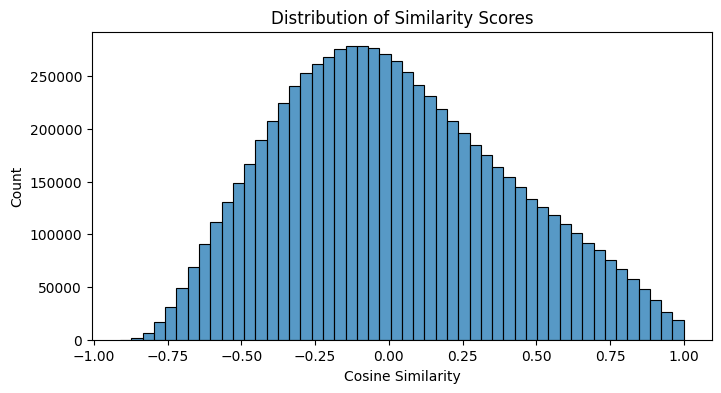

In [118]:
# Get features for all clusters
clusters = list(G.nodes())
feature_matrix = np.vstack([cluster_features[c] for c in clusters])

# Normalize features
scaler = StandardScaler()
feature_matrix_normalized = scaler.fit_transform(feature_matrix)

# Compute cosine similarity
similarity_matrix = cosine_similarity(feature_matrix_normalized)

# Also show distribution of similarities
plt.figure(figsize=(8, 4))
sns.histplot(similarity_matrix.flatten(), bins=50)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()


In [119]:
# 3. Add 'similarity_matrix' edges to the graph if unrelated but very similar
similarity_threshold = 0.9

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        ci, cj = clusters[i], clusters[j]      

        consider_similarity = True 
        # Connect if same therapeutic area
        if G.nodes[ci]['therapeutic_area'] == G.nodes[cj]['therapeutic_area']:
            G.add_edge(ci, cj, edge_type='therapeutic')
            consider_similarity = False 

        # Connect if same corporation
        if G.nodes[ci]['corporation'] == G.nodes[cj]['corporation']:
            G.add_edge(ci, cj, edge_type='corporation')
            consider_similarity = False 

        # Connect if same country
        if G.nodes[ci]['country'] == G.nodes[cj]['country']:
            G.add_edge(ci, cj, edge_type='country')
            consider_similarity = False 

        if not consider_similarity:
            continue
       # Connect if similar features
        if similarity_matrix[i, j] > similarity_threshold:
            G.add_edge(ci, cj, edge_type='similarity')
        
# Print graph statistics
print(f"\nGraph Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("\nEdge types distribution:")
edge_types = [d['edge_type'] for (u, v, d) in G.edges(data=True)]
for edge_type in set(edge_types):
    count = edge_types.count(edge_type)
    print(f"{edge_type}: {count} edges")



Graph Statistics:
Number of nodes: 2716
Number of edges: 1035502

Edge types distribution:
corporation: 200730 edges
country: 103988 edges
similarity: 8919 edges
therapeutic: 721865 edges


## 3. Defining the GNN model

In [120]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert graph to PyTorch Geometric format
def convert_to_pytorch_geometric(G, forecast_steps=FORECAST_STEPS):
    # Prepare edge index and type
    edge_index = []
    edge_type = []
    edge_type_dict = {
        'therapeutic': 0,
        'corporation': 1,
        'country': 2,
        'similarity': 3
    }
    
    for u, v, data in G.edges(data=True):
        # Add both directions for undirected graph
        edge_index.extend([[u, v], [v, u]])
        edge_type.extend([edge_type_dict[data['edge_type']]] * 2)
    
    # Convert node features
    x = torch.tensor([G.nodes[node]['features'] for node in G.nodes()], dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    # Create target tensor
    y_list = []
    for node in G.nodes():
        ts = G.nodes[node]['ts_data'][-forecast_steps:]
        y_list.append(ts)
    y = torch.tensor(y_list, dtype=torch.float)  # Shape: [num_nodes, forecast_steps]

    return Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)

# Convert graph and initialize model
data = convert_to_pytorch_geometric(G)

# Move data to device
data = data.to(device)


print(f"\nData Statistics:")
print(f"Number of node features: {data.x.size(1)}")
print(f"Number of edges: {data.edge_index.size(1)}")
print(f"Number of edge types: {len(torch.unique(data.edge_type))}")


Using device: cuda

Data Statistics:
Number of node features: 175
Number of edges: 2071004
Number of edge types: 4


In [121]:
def mape(y_true, y_pred):
    """
    Calculates Median Absolute Percentage Error
    Handles zero values in y_true by adding small epsilon
    """
    epsilon = 1e-7  # Small constant to avoid division by zero
    
    # Ensure tensors are on same device
    if y_true.device != y_pred.device:
        y_pred = y_pred.to(y_true.device)
    
    # Calculate absolute percentage error
    absolute_percentage_error = torch.abs((y_true - y_pred) / (y_true + epsilon))
    
    # Calculate median across all dimensions
    mape = torch.median(absolute_percentage_error)
    
    return mape

class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, forecast_steps=23, num_edge_types=4):
        super().__init__()
        self.num_edge_types = num_edge_types
        
        # Edge type attention weights
        self.edge_type_weights = nn.Parameter(torch.ones(num_edge_types))
        
        # Spatial: GAT layers per edge type
        self.spatial_layers = nn.ModuleList([
            GATConv(in_channels, hidden_channels, heads=4, concat=False) 
            for _ in range(num_edge_types)
        ])
        
        # Temporal: Transformer + Conv with normalization
        self.temporal_conv = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)

        self.temporal_attention = nn.MultiheadAttention(hidden_channels, num_heads=4)
        
        # Output layers
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.LayerNorm(hidden_channels),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, forecast_steps * 2)
        )
        
    def forward(self, x, edge_index, edge_type, batch=None):
        # 1. Spatial dependencies
        spatial_embeds = []
        for i in range(self.num_edge_types):
            mask = edge_type == i
            if mask.any():
                edge_index_i = edge_index[:, mask]
                spatial_embed = self.spatial_layers[i](x, edge_index_i)
                spatial_embeds.append(spatial_embed)
            else:
                spatial_embeds.append(torch.zeros_like(x))
        
        # Combine spatial embeddings
        spatial_out = sum(spatial_embeds)  # [num_nodes, hidden_channels]
        
        # 2. Temporal processing
        # Convolution branch - reshape properly
        temp_conv = spatial_out.unsqueeze(-1)  # [num_nodes, hidden_channels, 1]
        temp_conv = self.temporal_conv(temp_conv)  # Apply conv then norm
        temp_conv = temp_conv.squeeze(-1)  # Back to [num_nodes, hidden_channels]
        
        # Attention branch
        temp_attn, _ = self.temporal_attention(
            spatial_out.unsqueeze(0),
            spatial_out.unsqueeze(0),
            spatial_out.unsqueeze(0)
        )
        temp_attn = temp_attn.squeeze(0)
        
        # Combine temporal features
        combined = torch.cat([temp_conv, temp_attn], dim=-1)
        
        # 3. Generate forecasts with uncertainty
        output = self.decoder(combined)
        means, log_vars = output.chunk(2, dim=-1)
        
        return means, log_vars
    
    def mape_loss(self, means, log_vars, targets):
        return mape(targets, means)
    def mse_loss(self, predictions, targets):
        return F.mse_loss(predictions, targets)

# Convert graph and initialize model
model = TimeSeriesGNN(
    in_channels=data.x.size(1),
    hidden_channels=8,
    forecast_steps=2,
    num_edge_types=4
).to(device)

# Print model summary
print(f"\nModel Architecture:")
print(model)


Model Architecture:
TimeSeriesGNN(
  (spatial_layers): ModuleList(
    (0-3): 4 x GATConv(175, 8, heads=4)
  )
  (temporal_conv): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (temporal_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


## 4.Train-Test masking for validation

In [122]:
node_list = list(G.nodes())
test_nodes = [0, 5, 10, 50, 47, 48]

# Create boolean masks for training and testing nodes
test_mask = torch.tensor([cnl in test_nodes for cnl in node_list], dtype=torch.bool)
train_mask = ~test_mask
data.train_mask = train_mask.to(device)
data.test_mask = test_mask.to(device)

# Store original targets before zeroing out test values
y_all = data.y.clone()  # Clone first

# Extract training targets as a NumPy array
y_train = y_all[train_mask].cpu().numpy()  # Shape: [num_train_nodes, forecast_steps]

# Initialize the scaler
y_scaler = StandardScaler()

# Fit the scaler on the training targets
y_scaler.fit(y_train)
# Normalize all targets
y_all_normalized = y_scaler.transform(y_all.cpu().numpy())
y_all_normalized = torch.tensor(y_all_normalized, dtype=torch.float32).to(device)

# Modify data.y for training
data.y = y_all_normalized.clone()  # Clone again to prevent modifying y_all
data.y[test_mask] = 0.0

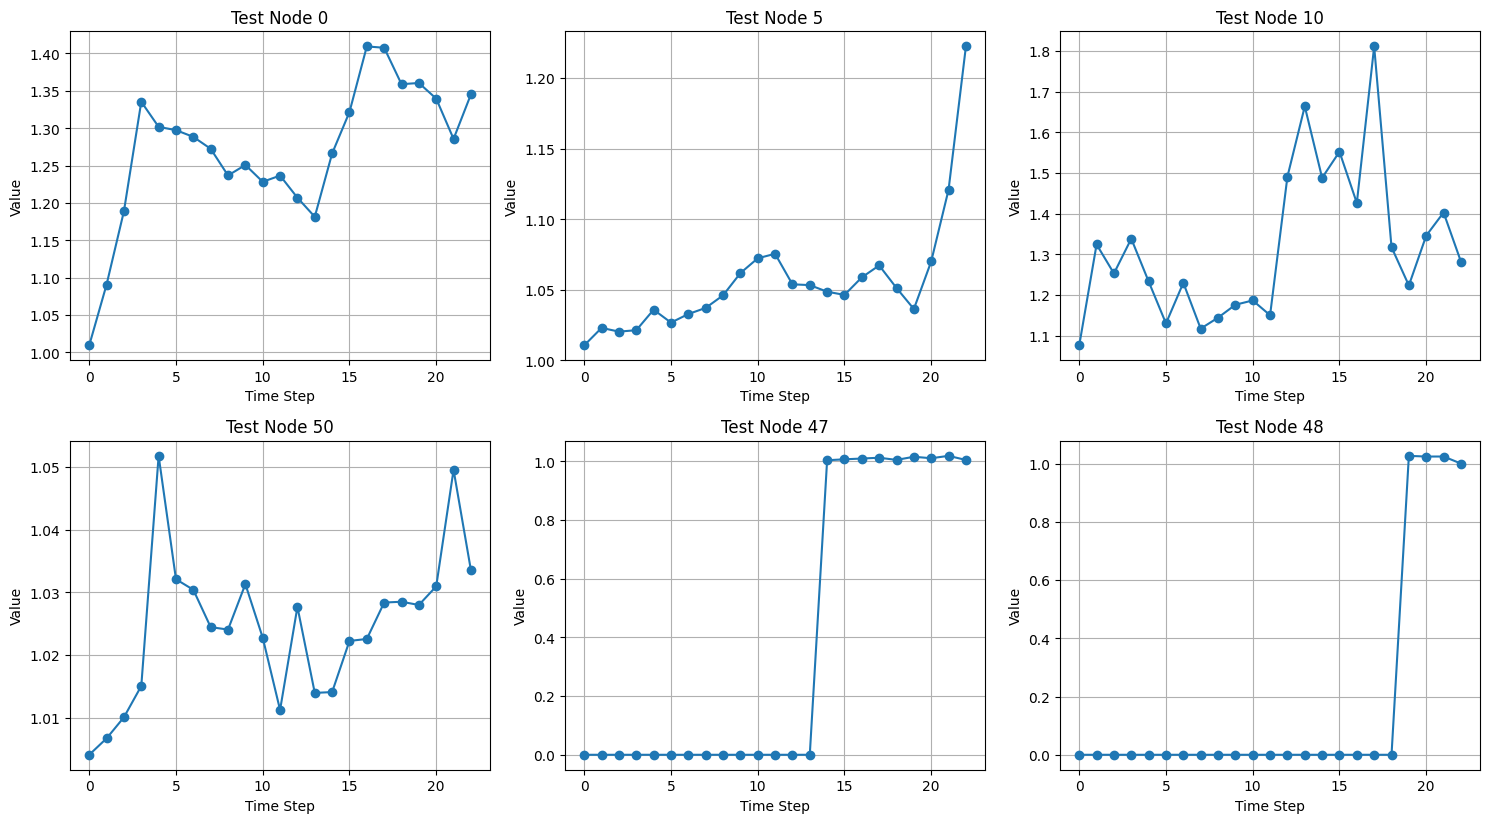

In [123]:
def plot_test_targets(test_ts_data, num_plots=9):
    """
    Plots the target values for the test nodes.
    
    Parameters:
    - test_ts_data: Dictionary of test node IDs and their ts_data
    - num_plots: Number of trajectories to plot (default is 9)
    """
    num_plots = min(num_plots, len(test_ts_data))
    
    # Determine the grid size for subplots (e.g., 3x3 for 9 plots)
    grid_size = int(np.ceil(np.sqrt(num_plots)))
    
    plt.figure(figsize=(5 * grid_size, 4 * grid_size))
    
    for i, (node, ts_data) in enumerate(test_ts_data.items()):
        if i >= num_plots:
            break
        plt.subplot(grid_size, grid_size, i + 1)
        plt.plot(ts_data, marker='o', label='True Target')
        plt.title(f'Test Node {node}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example Usage:
test_ts_data = {node: G.nodes[node]['ts_data'] for node in test_nodes}
plot_test_targets(test_ts_data, num_plots=6)

In [124]:
for i in range(50):
    ts_data = G.nodes[i]['ts_data']
    print(f"Node {i}: {ts_data}")

Node 0: [1.00939086 1.09076041 1.1889246  1.33535562 1.30173085 1.29737358
 1.28834617 1.27240485 1.23670667 1.25076946 1.22824167 1.23654831
 1.2069475  1.18141202 1.26613636 1.32161542 1.40939112 1.40761399
 1.35886112 1.36046942 1.33954151 1.28562275 1.345208  ]
Node 1: [1.15470941 1.1901979  1.24393064 1.30126335 1.30828549 1.32217423
 1.36015159 1.41472876 1.48710574 1.43543964 1.86106796 1.95924341
 1.95993778 1.76472923 1.80150863 1.82596849 1.64030198 1.77637679
 1.70996332 1.54622952 1.62484657 1.76988103 2.42133584]
Node 2: [1.01050393 1.03603677 1.05316887 1.06492188 1.05398393 1.04749824
 1.04931245 1.05865977 1.0456188  1.04904556 1.0378055  1.03347525
 1.03876561 1.04019658 1.08012242 1.11763643 1.09660144 1.09276461
 1.09992155 1.10191498 1.09078451 1.0814578  1.07473634]
Node 3: [1.00580931 1.01244597 1.0138342  1.01360594 1.03147693 1.
 1.05382242 1.0264946  1.02321537 1.02707163 1.02294972 1.01956748
 1.01853543 1.02246175 1.02159826 1.02661842 1.06365112 1.07549742
 

In [125]:
def test(model, data, y_scaler, y_all):
    model.eval()
    with torch.no_grad():
        means, log_vars = model(data.x, data.edge_index, data.edge_type)
        test_means = means[data.test_mask]
        test_log_vars = log_vars[data.test_mask]
        test_targets = y_all[data.test_mask]  # Use original (denormalized) targets

        # De-normalize the predictions
        test_means_denorm = y_scaler.inverse_transform(test_means.cpu().numpy())
        test_means_denorm = torch.tensor(test_means_denorm, dtype=torch.float32).to(device)

        # Calculate loss using denormalized values
        test_loss = model.mape_loss(test_means_denorm, test_log_vars, test_targets)
        print(f"Test Loss: {test_loss.item():.4f}")

    return test_means_denorm, test_targets


def plot_test_predictions(test_targets, test_means, num_plots=6):
    """
    Plots the first num_plots test targets vs. predicted means.

    Parameters:
    - test_targets: Tensor of true target values (denormalized)
    - test_means: Tensor of predicted mean values (denormalized)
    - num_plots: Number of trajectories to plot (default is 9)
    """
    num_plots = min(num_plots, len(test_targets))

    plt.figure(figsize=(15, 15))

    for i in range(num_plots):
        plt.subplot(3, 3, i + 1)
        true_target = test_targets[i].cpu().numpy()
        predicted_mean = test_means[i].cpu().numpy()

        plt.plot(true_target, label='True Target', marker='o')
        plt.plot(predicted_mean, label='Predicted Mean', marker='x')
        plt.title(f'Test Target vs. Predicted Mean {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def train(model, data, epochs=100, patience=10, log_frequency=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        means, log_vars = model(data.x, data.edge_index, data.edge_type)

        # Compute loss on training nodes
        loss = model.mse_loss(means[data.train_mask], y_all[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_means, val_log_vars = model(data.x, data.edge_index, data.edge_type)
            val_loss = model.mape_loss(val_means[data.test_mask], val_log_vars[data.test_mask], y_all[data.test_mask])

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % log_frequency == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Load the best model
    model.load_state_dict(best_model_state)
    return model

## 5. Model Execution 

In [126]:
# (Re)Initialize the model
model = TimeSeriesGNN(
    in_channels=data.x.size(1),
    hidden_channels=8,
    forecast_steps=FORECAST_STEPS,  # Predicting 23 target values
    num_edge_types=4
).to(device)

# Train the model
trained_model = train(model, data, epochs=200, patience=100, log_frequency=10, lr=0.01)

trained_model = train(model, data, epochs=200, patience=100, log_frequency=10, lr=0.001)


Epoch 0, Train Loss: 2.5288, Val Loss: 1.0388
Epoch 10, Train Loss: 1.0691, Val Loss: 0.4491
Epoch 20, Train Loss: 0.8072, Val Loss: 0.2206
Epoch 30, Train Loss: 0.7828, Val Loss: 0.2274
Epoch 40, Train Loss: 0.7695, Val Loss: 0.1901
Epoch 50, Train Loss: 0.7522, Val Loss: 0.1642
Epoch 60, Train Loss: 0.7405, Val Loss: 0.1800
Epoch 70, Train Loss: 0.7430, Val Loss: 0.1707
Epoch 80, Train Loss: 0.7392, Val Loss: 0.1672
Epoch 90, Train Loss: 0.7373, Val Loss: 0.1652
Epoch 100, Train Loss: 0.7311, Val Loss: 0.1657
Epoch 110, Train Loss: 0.7283, Val Loss: 0.1697
Epoch 120, Train Loss: 0.7331, Val Loss: 0.1646
Epoch 130, Train Loss: 0.7258, Val Loss: 0.1682
Epoch 140, Train Loss: 0.7278, Val Loss: 0.1718
Early stopping at epoch 149
Epoch 0, Train Loss: 0.7152, Val Loss: 0.1847
Epoch 10, Train Loss: 0.7133, Val Loss: 0.1994
Epoch 20, Train Loss: 0.7071, Val Loss: 0.2037
Epoch 30, Train Loss: 0.6986, Val Loss: 0.1915
Epoch 40, Train Loss: 0.6932, Val Loss: 0.1999
Epoch 50, Train Loss: 0.6865,

Test Loss: 0.9785


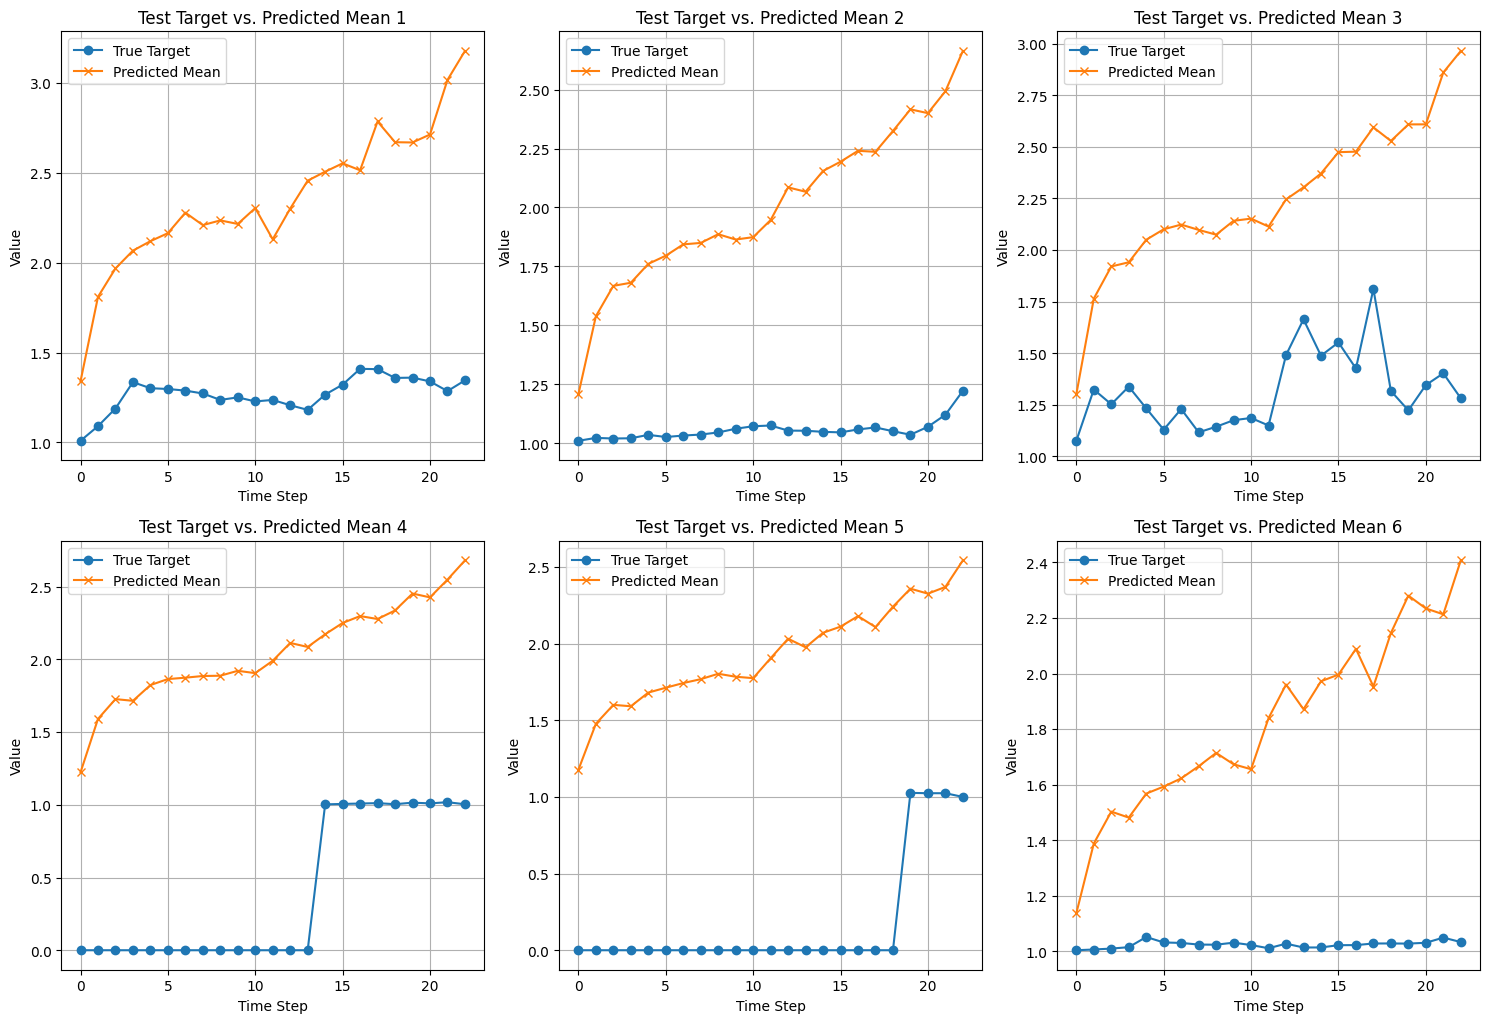

(tensor([[1.3395, 1.8093, 1.9672, 2.0663, 2.1189, 2.1633, 2.2774, 2.2083, 2.2343,
          2.2147, 2.3029, 2.1292, 2.2999, 2.4552, 2.5051, 2.5515, 2.5129, 2.7841,
          2.6690, 2.6675, 2.7117, 3.0150, 3.1760],
         [1.2085, 1.5390, 1.6677, 1.6808, 1.7609, 1.7955, 1.8436, 1.8496, 1.8866,
          1.8640, 1.8741, 1.9467, 2.0852, 2.0667, 2.1549, 2.1940, 2.2403, 2.2360,
          2.3244, 2.4161, 2.4000, 2.4927, 2.6636],
         [1.3012, 1.7647, 1.9204, 1.9407, 2.0499, 2.1006, 2.1233, 2.0975, 2.0744,
          2.1417, 2.1521, 2.1136, 2.2453, 2.3037, 2.3707, 2.4741, 2.4766, 2.5942,
          2.5285, 2.6086, 2.6089, 2.8601, 2.9643],
         [1.2228, 1.5909, 1.7271, 1.7155, 1.8236, 1.8650, 1.8746, 1.8861, 1.8881,
          1.9218, 1.9058, 1.9908, 2.1135, 2.0859, 2.1731, 2.2508, 2.2983, 2.2780,
          2.3369, 2.4533, 2.4269, 2.5490, 2.6812],
         [1.1772, 1.4771, 1.6004, 1.5913, 1.6804, 1.7122, 1.7426, 1.7679, 1.8032,
          1.7839, 1.7745, 1.9045, 2.0317, 1.9757, 2.0704, 

In [127]:
# Test the model
test_means_denorm, test_targets_denorm = test(model, data, y_scaler, y_all)
# Call the function to plot the first 9 test trajectories
plot_test_predictions(test_targets_denorm, test_means_denorm, num_plots=6)

test_means_denorm, test_targets_denorm